# Tutorial for Haystack usage

References:
* https://colab.research.google.com/github/deepset-ai/haystack-cookbook/blob/main/notebooks/mixtral-8x7b-for-web-qa.ipynb#scrollTo=pwp6S_iAC1DR

In [1]:
%pip install -q haystack-ai==2.1.1
%pip install -q huggingface-hub==0.23.0
%pip install -q transformers==4.40.2
%pip install -q accelerate==0.30.1
%pip install -q sentencepiece==0.2.0
%pip install -q datasets==2.19.1
%pip install -q sentence-transformers==2.7.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.0/319.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.6/320.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [29]:
import os
import yaml
from google.colab import drive
from getpass import getpass

drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
# Read YAML file
f_path = "/content/drive/MyDrive/GitHub/python-codebase/machine_learning/private_keys.yml"
with open(f_path, 'r') as stream:
    data_loaded = yaml.safe_load(stream)
os.environ['HF_API_TOKEN'] = data_loaded['HF_API_KEY']
os.environ['GITHUB_TOKEN'] = data_loaded['GITHUB_TOKEN']

## 1. Prompt the Model - Standalone

In [ ]:
from haystack.components.generators import HuggingFaceAPIGenerator

#model_name = "mistralai/Mistral-7B-Instruct-v0.2"
model_name = "HuggingFaceH4/zephyr-7b-beta"
#model_name = "google/gemma-7b"
#model_name = "google/flan-ul2"

generator = HuggingFaceAPIGenerator(
  api_type="serverless_inference_api",
  api_params={"model": model_name}
)

In [ ]:
result = generator.run("What's Natural Language Processing?", generation_kwargs={"max_new_tokens": 350})
print(result["replies"][0])



Natural Language Processing (NLP) is a subfield of Artificial Intelligence (AI) and Computer Science that deals with the interactions between computers and human (natural) languages. NLP is a complex field that involves a variety of techniques from linguistics, computer science, and artificial intelligence.

NLP is used to enable computers to understand, interpret, and generate human language. It is a critical component of many AI applications, including virtual assistants, chatbots, search engines, and language translation services.

NLP is essential for AI systems to understand and respond to human language in a more natural and intuitive way. It allows computers to process and analyze large volumes of text, identify patterns and relationships, and generate insights and recommendations based on that analysis.

NLP is also used to improve the accuracy and efficiency of language translation services, making it easier for people to communicate across language barriers.

In summary, NL

## 2. Use the model in a full RAG pipeline (on the web)

Note: Instead of the LinkContentFetcher, we can change this pipeline to use our own data source (such as a vector databse, documentation...)

In [ ]:
from haystack.components.fetchers.link_content import LinkContentFetcher
from haystack.components.converters import HTMLToDocument
from haystack.components.preprocessors import DocumentSplitter
from haystack.components.rankers import TransformersSimilarityRanker
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack import Pipeline

In [ ]:
fetcher = LinkContentFetcher()
converter = HTMLToDocument()
document_splitter = DocumentSplitter(split_by="word", split_length=50)
similarity_ranker = TransformersSimilarityRanker(top_k=3)

In [ ]:
prompt_template = """
According to these documents:

{% for doc in documents %}
  {{ doc.content }}
{% endfor %}

Answer the given question: {{question}}
Answer:
"""
prompt_builder = PromptBuilder(template=prompt_template)

In [ ]:
pipeline = Pipeline()
pipeline.add_component("fetcher", fetcher)
pipeline.add_component("converter", converter)
pipeline.add_component("splitter", document_splitter)
pipeline.add_component("ranker", similarity_ranker)
pipeline.add_component("prompt_builder", prompt_builder)
pipeline.add_component("llm", generator)

In [ ]:
pipeline.connect("fetcher.streams", "converter.sources")
pipeline.connect("converter.documents", "splitter.documents")
pipeline.connect("splitter.documents", "ranker.documents")
pipeline.connect("ranker.documents", "prompt_builder.documents")
pipeline.connect("prompt_builder.prompt", "llm.prompt")

🚅 Components
  - fetcher: LinkContentFetcher
  - converter: HTMLToDocument
  - splitter: DocumentSplitter
  - ranker: TransformersSimilarityRanker
  - prompt_builder: PromptBuilder
  - llm: HuggingFaceAPIGenerator
🛤️ Connections
  - fetcher.streams -> converter.sources (List[ByteStream])
  - converter.documents -> splitter.documents (List[Document])
  - splitter.documents -> ranker.documents (List[Document])
  - ranker.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

In [ ]:
question = "What do graphs have to do with Haystack?"
result = pipeline.run(
  {
    "prompt_builder": {"question": question},
    "ranker": {"query": question},
    "fetcher": {"urls": ["https://haystack.deepset.ai/blog/introducing-haystack-2-beta-and-advent"]},
    "llm":{"generation_kwargs": {"max_new_tokens": 350}}
  }
)
print(result['llm']['replies'][0])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

 In Haystack 1.x, graphs were used to implement pipelines as directed acyclic graphs (DAGs), while in Haystack 2.0, graphs are still used but they are now directed (multi)graphs that can branch out, join, and cycle back to another component, allowing for more complex pipelines with features such as retries and loops. This shift towards more explicit component functionality is aimed at making the framework more transparent and easier to use.


# 3. RAG pipeline

References:
* https://haystack.deepset.ai/tutorials/27_first_rag_pipeline

In [ ]:
from datasets import load_dataset
from haystack import Pipeline, Document
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.builders import PromptBuilder
from haystack.components.generators import HuggingFaceAPIGenerator

In [ ]:
if False:
  # Try document store
  document_store = InMemoryDocumentStore()
  document_store.write_documents([
    Document(content="My name is Jean and I live in Paris."),
    Document(content="My name is Mark and I live in Berlin."),
    Document(content="My name is Giorgio and I live in Rome.")
])

In [ ]:
# Load dataset
dataset = load_dataset("bilgeyucel/seven-wonders", split="train")
docs = [Document(content=doc["content"], meta=doc["meta"]) for doc in dataset]
print(dataset[0])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/151 [00:00<?, ? examples/s]

{'id': 'b3de1a673c1eb2876585405395a10c3d', 'content': 'The Colossus of Rhodes (Ancient Greek: ὁ Κολοσσὸς Ῥόδιος, romanized:\xa0ho Kolossòs Rhódios Greek: Κολοσσός της Ρόδου, romanized:\xa0Kolossós tes Rhódou)[a] was a statue of the Greek sun-god Helios, erected in the city of Rhodes, on the Greek island of the same name, by Chares of Lindos in 280\xa0BC. One of the Seven Wonders of the Ancient World, it was constructed to celebrate the successful defence of Rhodes city against an attack by Demetrius Poliorcetes, who had besieged it for a year with a large army and navy.\nAccording to most contemporary descriptions, the Colossus stood approximately 70 cubits, or 33 metres (108 feet) high – approximately the height of the modern Statue of Liberty from feet to crown – making it the tallest statue in the ancient world.[2] It collapsed during the earthquake of 226 BC, although parts of it were preserved. In accordance with a certain oracle, the Rhodians did not build it again.[3] John Malal

In [ ]:
# Initalize a Document Embedder
'''
To store your data in the DocumentStore with embeddings, initialize a SentenceTransformersDocumentEmbedder with the model name and call warm_up() to download the embedding model.
'''
doc_embedder = SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
doc_embedder.warm_up()

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
#document_store = InMemoryDocumentStore()
#document_store.write_documents(docs)

In [ ]:
# Write Documents to the DocumentStore
'''
The embedder will create embeddings for each document and save these embeddings in Document object’s embedding field.
Then, you can write the Documents to the DocumentStore with write_documents() method.
'''
document_store = InMemoryDocumentStore()
docs_with_embeddings = doc_embedder.run(docs)
document_store.write_documents(docs_with_embeddings["documents"])

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

151

## Building the RAG Pipeline

In [ ]:
# Initialize a Text Embedder
'''
Initialize a text embedder to create an embedding for the user query.
The created embedding will later be used by the Retriever to retrieve relevant documents from the DocumentStore.
'''
text_embedder = SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")

In [ ]:
# Initialize the Retriever
'''
Initialize a InMemoryEmbeddingRetriever and make it use the InMemoryDocumentStore you initialized earlier in this tutorial.
This Retriever will get the relevant documents to the query.
'''
retriever = InMemoryEmbeddingRetriever(document_store)

In [ ]:
# Define a Template Prompt
'''
Create a custom prompt for a generative question answering task using the RAG approach.
The prompt should take in two parameters: documents, which are retrieved from a document store, and a question from the user.
Use the Jinja2 looping syntax to combine the content of the retrieved documents in the prompt.

Next, initialize a PromptBuilder instance with your prompt template.
The PromptBuilder, when given the necessary values, will automatically fill in the variable values and generate a complete prompt.
This approach allows for a more tailored and effective question-answering experience.
'''

template = """
Given the following information, answer the question.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{question}}
Answer:
"""

prompt_builder = PromptBuilder(template=template)

In [ ]:
# Initialize a Generator
'''
Generators are the components that interact with large language models (LLMs).
'''
#model_name = "mistralai/Mistral-7B-Instruct-v0.2"
model_name = "HuggingFaceH4/zephyr-7b-beta"
#model_name = "google/gemma-7b"
#model_name = "google/flan-ul2"

generator = HuggingFaceAPIGenerator(
  api_type="serverless_inference_api",
  api_params={"model": model_name}
)

In [ ]:
# Try LLM
result = generator.run("What's Natural Language Processing?", generation_kwargs={"max_new_tokens": 350})
print(result["replies"][0])



Natural Language Processing (NLP) is a subfield of Artificial Intelligence (AI) and Computer Science that deals with the interactions between computers and human (natural) languages. NLP is a complex field that involves a variety of techniques from linguistics, computer science, and artificial intelligence.

NLP is used to enable computers to understand, interpret, and generate human language. It is a critical component of many AI applications, including virtual assistants, chatbots, search engines, and language translation services.

NLP is essential for AI systems to understand and respond to human language in a more natural and intuitive way. It allows computers to process and analyze large volumes of text, identify patterns and relationships, and generate insights and recommendations based on that analysis.

NLP is also used to improve the accuracy and efficiency of language translation services, making it easier for people to communicate across language barriers.

In summary, NL

In [ ]:
# Build the Pipeline
'''
To build a pipeline, add all components to your pipeline and connect them.
Create connections from text_embedder’s “embedding” output to “query_embedding” input of retriever, from retriever to prompt_builder and from prompt_builder to llm.
Explicitly connect the output of retriever with “documents” input of the prompt_builder to make the connection obvious as prompt_builder has two inputs (“documents” and “question”).
'''
# Set up pipeline
basic_rag_pipeline = Pipeline()

# Add components to your pipeline
basic_rag_pipeline.add_component("text_embedder", text_embedder)
basic_rag_pipeline.add_component("retriever", retriever)
basic_rag_pipeline.add_component("prompt_builder", prompt_builder)
basic_rag_pipeline.add_component("llm", generator)

# Now, connect the components to each other
basic_rag_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")
basic_rag_pipeline.connect("retriever", "prompt_builder.documents")
basic_rag_pipeline.connect("prompt_builder", "llm")

🚅 Components
  - text_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - llm: HuggingFaceAPIGenerator
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

In [ ]:
question = "What does Rhodes Statue look like?"
response = basic_rag_pipeline.run(
    {
      "text_embedder":  {"text": question},
      "prompt_builder": {"question": question}
    }
)
print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 While scholars do not know what the statue looked like, they do have a good idea of what the head and face looked like, as it was of a standard rendering at the time. The head would have had curly hair with evenly spaced spikes of bronze or silver flame radiating, similar to the images found on contemporary Rhodian coins.


In [ ]:
# Visualize pipelines
basic_rag_pipeline.draw("rag_pipeline.png")

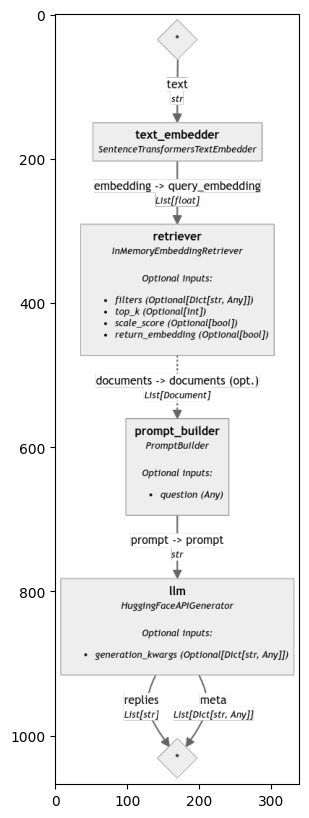

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('rag_pipeline.png')
plt.figure(figsize = (100,10))
plt.imshow(img)
plt.show()

![](/content/rag_pipeline.png)

# 4. Generating Structured Output with Loop-Based Auto-Correction

References:
* https://haystack.deepset.ai/tutorials/28_structured_output_with_loop
* Remove Tememetry (sharing statistics w/ Haystack): https://docs.haystack.deepset.ai/docs/telemetry
* https://pypi.org/project/pydantic/
* https://docs.haystack.deepset.ai/docs/generators!

In [44]:
import os
import logging
import json
import random
import pydantic
from pydantic import ValidationError
from pydantic import BaseModel
from typing import Optional, List
from haystack import component
from haystack.components.builders import PromptBuilder
from haystack.components.generators import HuggingFaceAPIGenerator
from haystack import Pipeline

In [45]:
os.environ["HAYSTACK_TELEMETRY_ENABLED"] = 'False'

In [46]:
logging.basicConfig()
logging.getLogger("canals.pipeline.pipeline").setLevel(logging.DEBUG)

In [47]:
# Pydantic example
if False:
  from datetime import datetime
  from typing import List, Optional
  from pydantic import BaseModel

  class User(BaseModel):
      id: int
      name: str = 'John Doe'
      signup_ts: Optional[datetime] = None
      friends: List[int] = []

  external_data = {'id': '123', 'signup_ts': '2017-06-01 12:22', 'friends': [1, '2', b'3']}
  user = User(**external_data)
  print(user)
  #> User id=123 name='John Doe' signup_ts=datetime.datetime(2017, 6, 1, 12, 22) friends=[1, 2, 3]
  print(user.id)
  #> 123
  # Error, since data type for 'friends' is incorrect
  User(**{'id': '123', 'signup_ts': '2017-06-01 12:22', 'friends': ['A']})
  #>ValidationError: 1 validation error for User friends. Input should be a valid integer, unable to parse string as an integer [type=int_parsing, input_value='A', input_type=str]

In [48]:
# Defining a Schema to Parse the JSON Object
'''
Define a simple JSON schema for the data you want to extract from a text passsage using the LLM.
As the first step, define two Pydantic models, City and CitiesData, with suitable fields and types.
'''
class City(BaseModel):
    name: str
    country: str
    population: int

class CitiesData(BaseModel):
    cities: List[City]

# Generate a JSON schema from Pydantic models using schema_json()
json_schema = CitiesData.schema_json(indent=2)

In [49]:
print(json_schema)

{
  "$defs": {
    "City": {
      "properties": {
        "name": {
          "title": "Name",
          "type": "string"
        },
        "country": {
          "title": "Country",
          "type": "string"
        },
        "population": {
          "title": "Population",
          "type": "integer"
        }
      },
      "required": [
        "name",
        "country",
        "population"
      ],
      "title": "City",
      "type": "object"
    }
  },
  "properties": {
    "cities": {
      "items": {
        "$ref": "#/$defs/City"
      },
      "title": "Cities",
      "type": "array"
    }
  },
  "required": [
    "cities"
  ],
  "title": "CitiesData",
  "type": "object"
}


In [50]:
# Creating a Custom Component: OutputValidator
'''
OutputValidator is a custom component that validates if the JSON object the LLM generates complies with the provided Pydantic model.
If it doesn’t, OutputValidator returns an error message along with the incorrect JSON object to get it fixed in the next loop.
'''
# Define the component input parameters
@component
class OutputValidator:
    """

    Attributes:
      pydantic_model:
      iteration_counter:
    """
    def __init__(self, pydantic_model: pydantic.BaseModel):
        self.pydantic_model = pydantic_model
        self.iteration_counter = 0

    # Define the component output
    @component.output_types(valid_replies=List[str], invalid_replies=Optional[List[str]], error_message=Optional[str])
    def run(self, replies: List[str]):

        self.iteration_counter += 1

        ## Try to parse the LLM's reply ##
        # If the LLM's reply is a valid object, return `"valid_replies"`
        try:
            output_dict = json.loads(replies[0])
            self.pydantic_model.parse_obj(output_dict)
            print(
                f"OutputValidator at Iteration {self.iteration_counter}: Valid JSON from LLM - No need for looping: {replies[0]}"
            )
            return {"valid_replies": replies}

        # If the LLM's reply is corrupted or not valid, return "invalid_replies" and the "error_message" for LLM to try again
        except (ValueError, ValidationError) as e:
            print(
                f"OutputValidator at Iteration {self.iteration_counter}: Invalid JSON from LLM - Let's try again.\n"
                f"Output from LLM:\n {replies[0]} \n"
                f"Error from OutputValidator: {e}"
            )
            return {"invalid_replies": replies, "error_message": str(e)}


In [51]:
# Create an OutputValidator instance with CitiesData that you have created before.
output_validator = OutputValidator(pydantic_model=CitiesData)

In [52]:
# Creating the Prompt
'''
Write instructions for the LLM for converting a passage into a JSON format.
Ensure the instructions explain how to identify and correct errors if the JSON doesn’t match the required schema.
Once you create the prompt, initialize PromptBuilder to use it.
'''

prompt_template = """
Create a JSON object from the information present in this passage: {{passage}}.
Only use information that is present in the passage. Follow this JSON schema, but only return the actual instances without any additional schema definition:
{{schema}}
Make sure your response is a dict and not a list.
{% if invalid_replies and error_message %}
  You already created the following output in a previous attempt: {{invalid_replies}}
  However, this doesn't comply with the format requirements from above and triggered this Python exception: {{error_message}}
  Correct the output and try again. Just return the corrected output without any extra explanations.
{% endif %}
"""
prompt_builder = PromptBuilder(template=prompt_template)

In [53]:
# Initalizing the Generator
'''
Generators are the components that interact with large language models (LLMs).
'''
#model_name = "mistralai/Mistral-7B-Instruct-v0.2"
#model_name = "HuggingFaceH4/zephyr-7b-beta"
#model_name = "google/gemma-7b"
#model_name = "google/flan-ul2"
model_name = 'mistralai/Mixtral-8x7B-Instruct-v0.1'

generator = HuggingFaceAPIGenerator(
  api_type="serverless_inference_api",
  api_params={"model": model_name},
  token=Secret.from_token(data_loaded['HF_API_KEY'])
)

In [54]:
# Building the Pipeline
'''
Add all components to your pipeline and connect them.
Add connections from output_validator back to the prompt_builder for cases where the produced JSON doesn’t comply with the JSON schema.
Set max_loops_allowed to avoid infinite looping
'''

pipeline = Pipeline(max_loops_allowed=10)

# Add components to your pipeline
pipeline.add_component(instance=prompt_builder, name="prompt_builder")
pipeline.add_component(instance=generator, name="llm")
pipeline.add_component(instance=output_validator, name="output_validator")

# Now, connect the components to each other
pipeline.connect("prompt_builder", "llm")
pipeline.connect("llm", "output_validator")
# If a component has more than one output or input, explicitly specify the connections:
pipeline.connect("output_validator.invalid_replies", "prompt_builder.invalid_replies")
pipeline.connect("output_validator.error_message", "prompt_builder.error_message")

🚅 Components
  - prompt_builder: PromptBuilder
  - llm: HuggingFaceAPIGenerator
  - output_validator: OutputValidator
🛤️ Connections
  - prompt_builder.prompt -> llm.prompt (str)
  - llm.replies -> output_validator.replies (List[str])
  - output_validator.invalid_replies -> prompt_builder.invalid_replies (Optional[List[str]])
  - output_validator.error_message -> prompt_builder.error_message (Optional[str])

In [55]:
# Visualize pipeline
pipeline.draw("auto-correct-pipeline.png")

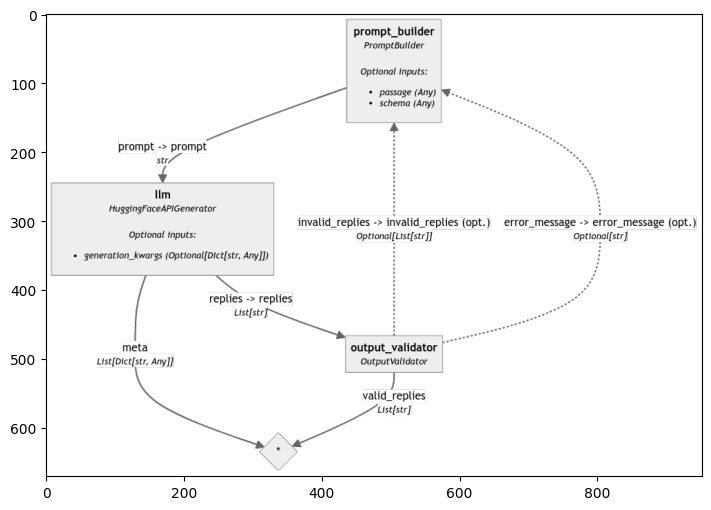

In [56]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('auto-correct-pipeline.png')
plt.figure(figsize = (40,6))
plt.imshow(img)
plt.show()

In [57]:
# Testing the Pipeline
'''
Run the pipeline with an example passage that you want to convert into a JSON format
and the json_schema you have created for CitiesData
'''
passage = "Berlin is the capital of Germany. It has a population of 3,850,809. Paris, France's capital, has 2.161 million residents. Lisbon is the capital and the largest city of Portugal with the population of 504,718."
result = pipeline.run({"prompt_builder": {"passage": passage, "schema": json_schema}})

OutputValidator at Iteration 1: Valid JSON from LLM - No need for looping: 
{
  "cities": [
    {
      "name": "Berlin",
      "country": "Germany",
      "population": 3850809
    },
    {
      "name": "Paris",
      "country": "France",
      "population": 2161000
    },
    {
      "name": "Lisbon",
      "country": "Portugal",
      "population": 504718
    }
  ]
}
































































































































































































































































































































































































In [58]:
# Print the Correct JSON
valid_reply = result["output_validator"]["valid_replies"][0]
valid_json = json.loads(valid_reply)
print(valid_json)

{'cities': [{'name': 'Berlin', 'country': 'Germany', 'population': 3850809}, {'name': 'Paris', 'country': 'France', 'population': 2161000}, {'name': 'Lisbon', 'country': 'Portugal', 'population': 504718}]}


In [59]:
'''
# Example (w/o pipelines)
#model_name = "mistralai/Mistral-7B-v0.1"
model_name = "HuggingFaceH4/zephyr-7b-beta"
#model_name = "google/gemma-7b"
#model_name = "google/flan-ul2"

generator1 = HuggingFaceAPIGenerator(
  api_type="serverless_inference_api",
  api_params={"model": model_name}
)
input_prompt = (
    prompt_template
    .replace('{{passage}}', passage)
    .replace('{{schema}}', json_schema)
    .split('{% if invalid_replies and error_message %}')[0]
)
result = generator1.run(input_prompt, generation_kwargs={"max_new_tokens": 250})
print(result["replies"][0])
'''
print()

In [60]:
#print(input_prompt)

In [61]:
'''
# Example (w/o validator)
#result = generator.run(passage, generation_kwargs={"max_new_tokens": 1000})
#print(result["replies"][0])

# Instantiate components
prompt_builder = PromptBuilder(template=prompt_template)
generator = HuggingFaceAPIGenerator(
  api_type="serverless_inference_api",
  api_params={"model": model_name}
)

# Add components to your pipeline
pipeline1 = Pipeline(max_loops_allowed=10)
pipeline1.add_component(instance=prompt_builder, name="prompt_builder")
pipeline1.add_component(instance=generator, name="llm")

# Now, connect the components to each other
pipeline1.connect("prompt_builder", "llm")
'''
print()

In [62]:
#result = pipeline1.run({"prompt_builder": {"passage": 'City - Madrid - Population - 10M', "schema": json_schema}})
#result

In [63]:
#result['llm']['replies'][0]

# 5. Evaluating RAG Pipelines

References:
* https://haystack.deepset.ai/tutorials/35_evaluating_rag_pipelines

In [40]:
import os
import random
import pandas as pd

from typing import List
from haystack.utils import Secret
from datasets import load_dataset
from haystack import Document
from haystack import Pipeline
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.components.writers import DocumentWriter
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.document_stores.types import DuplicatePolicy
from haystack.components.builders import AnswerBuilder, PromptBuilder
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.generators import HuggingFaceAPIGenerator

In [4]:
os.environ["HAYSTACK_TELEMETRY_ENABLED"] = 'False'

In [5]:
# Retrieve documents
dataset = load_dataset("vblagoje/PubMedQA_instruction", split="train")
dataset = dataset.select(range(1000))
all_documents = [Document(content=doc["context"]) for doc in dataset]
all_questions = [doc["instruction"] for doc in dataset]
all_ground_truth_answers = [doc["response"] for doc in dataset]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/272458 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [7]:
print(all_documents[0])
print(all_questions[0])
print(all_ground_truth_answers[0])

Document(id=f6fde0752a035f7a15860dfa6c45d3ee05380198f18abf43b7b4923ec44c9985, content: 'Chronic rhinosinusitis (CRS) is a heterogeneous disease with an uncertain pathogenesis. Group 2 inna...')
Are group 2 innate lymphoid cells ( ILC2s ) increased in chronic rhinosinusitis with nasal polyps or eosinophilia?
As ILC2s are elevated in patients with CRSwNP, they may drive nasal polyp formation in CRS. ILC2s are also linked with high tissue and blood eosinophilia and have a potential role in the activation and survival of eosinophils during the Th2 immune response. The association of innate lymphoid cells in CRS provides insights into its pathogenesis.


In [31]:
# Initalizing the Generator
'''
Generators are the components that interact with large language models (LLMs).
'''
#model_name = "mistralai/Mixtral-8x7B-Instruct-v0.1"
model_name = "HuggingFaceH4/zephyr-7b-beta"
#model_name = "google/gemma-7b-it"
#model_name = "google/flan-ul2"

generator = HuggingFaceAPIGenerator(
  api_type="serverless_inference_api",
  api_params={"model": model_name},
  token=Secret.from_token(data_loaded['HF_API_KEY'])
)

In [32]:
# RAG Pipeline (I) - In memory VectorDB
document_store = InMemoryDocumentStore()

document_embedder = SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
document_writer = DocumentWriter(document_store=document_store, policy=DuplicatePolicy.SKIP)

indexing = Pipeline()
indexing.add_component(instance=document_embedder, name="document_embedder")
indexing.add_component(instance=document_writer, name="document_writer")

indexing.connect("document_embedder.documents", "document_writer.documents")
indexing.run({"document_embedder": {"documents": all_documents}})

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

{'document_writer': {'documents_written': 1000}}

In [33]:
# RAG Pipeline (II) -

template = """
  You have to answer the following question based on the given context information only.

  Context:
  {% for document in documents %}
      {{ document.content }}
  {% endfor %}

  Question: {{question}}
  Answer:
"""

rag_pipeline = Pipeline()
rag_pipeline.add_component(
    "query_embedder", SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
)
rag_pipeline.add_component("retriever", InMemoryEmbeddingRetriever(document_store, top_k=3))
rag_pipeline.add_component("prompt_builder", PromptBuilder(template=template))
rag_pipeline.add_component("generator", generator)
rag_pipeline.add_component("answer_builder", AnswerBuilder())

rag_pipeline.connect("query_embedder", "retriever.query_embedding")
rag_pipeline.connect("retriever", "prompt_builder.documents")
rag_pipeline.connect("prompt_builder", "generator")
rag_pipeline.connect("generator.replies", "answer_builder.replies")
rag_pipeline.connect("generator.meta", "answer_builder.meta")
rag_pipeline.connect("retriever", "answer_builder.documents")

🚅 Components
  - query_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - generator: HuggingFaceAPIGenerator
  - answer_builder: AnswerBuilder
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - retriever.documents -> answer_builder.documents (List[Document])
  - prompt_builder.prompt -> generator.prompt (str)
  - generator.replies -> answer_builder.replies (List[str])
  - generator.meta -> answer_builder.meta (List[Dict[str, Any]])

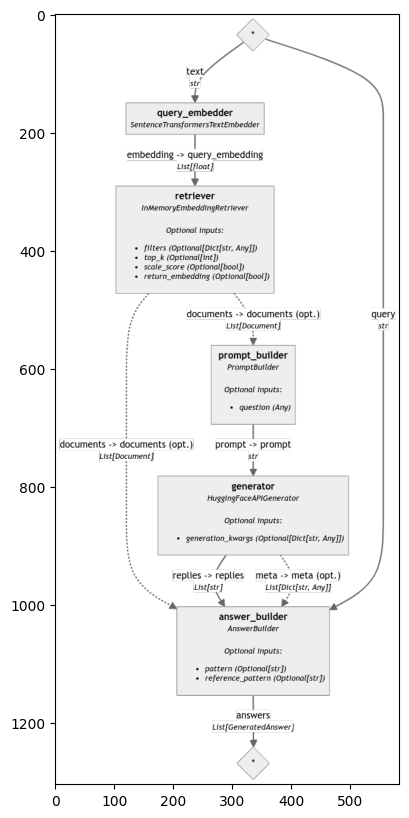

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Visualize pipeline
rag_pipeline.draw("rag-pipeline-eval.png")
img = mpimg.imread('rag-pipeline-eval.png')
plt.figure(figsize = (40,10))
plt.imshow(img)
plt.show()

In [34]:
# Ask a question
question = "Do high levels of procalcitonin in the early phase after pediatric liver transplantation indicate poor postoperative outcome?"

response = rag_pipeline.run(
    {"query_embedder": {"text": question}, "prompt_builder": {"question": question}, "answer_builder": {"query": question}}
)
print(response["answer_builder"]["answers"][0].data)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 Yes, according to the given context, high levels of procalcitonin on postoperative day 2 in pediatric liver transplantation patients are associated with higher International Normalized Ratio values on postoperative day 5, higher incidence of primary graft non-function, longer stay in the pediatric intensive care unit, and longer stay on mechanical ventilation, but there is no correlation between PCT elevation and systemic infection.


In [37]:
## Evaluate the Pipeline
'''
Document Mean Reciprocal Rank: Evaluates retrieved documents using ground truth labels. It checks at what rank ground truth documents appear in the list of retrieved documents.
Semantic Answer Similarity: Evaluates predicted answers using ground truth labels. It checks the semantic similarity of a predicted answer and the ground truth answer using a fine-tuned language model.
Faithfulness: Uses an LLM to evaluate whether a generated answer can be inferred from the provided contexts. Does not require ground truth labels.
'''
from haystack.components.evaluators.document_mrr import DocumentMRREvaluator
from haystack.components.evaluators.faithfulness import FaithfulnessEvaluator
from haystack.components.evaluators.sas_evaluator import SASEvaluator
from haystack.evaluation.eval_run_result import EvaluationRunResult

In [36]:
# Get all answers for a subsample of questions
questions, ground_truth_answers, ground_truth_docs = zip(*random.sample(list(zip(all_questions, all_ground_truth_answers, all_documents)), 25))
rag_answers = []
retrieved_docs = []

for question in list(questions):
  response = rag_pipeline.run({"query_embedder": {"text": question},
                              "prompt_builder": {"question": question},
                              "answer_builder": {"query": question}})
  print(f"Question: {question}")
  print("Answer from pipeline:")
  print(response["answer_builder"]["answers"][0].data)
  print("\n-----------------------------------\n")

  rag_answers.append(response["answer_builder"]["answers"][0].data)
  retrieved_docs.append(response["answer_builder"]["answers"][0].documents)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is the anterior cingulate cortex a critical hub for pain-induced depression?
Answer from pipeline:
 Yes, based on the study that compared the role of the anterior cingulate cortex (ACC) and the posterior insular cortex in pain-induced depression. The study found that a lesion in the ACC prevented the anxiodepressive consequences of chronic pain, while a lesion in the posterior insular cortex did not affect the anxiodepressive consequences of pain. Additionally, optogenetic stimulation of the ACC was sufficient to induce anxiety and depressive-like behaviors in naïve animals. These findings suggest that the ACC is a critical hub for pain-induced depression.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does pRMT5 enhance generation of induced pluripotent stem cells from dairy goat embryonic fibroblasts via down-regulation of p53?
Answer from pipeline:
 Yes, according to the given context, overexpression of PRMT5 in combination with OSKM significantly increased the number of AP positive iPS-like colony-derived GEFs and enhanced somatic cell reprogramming by down-regulating p53, p21, and caspase 3 in dairy goats.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does peroxiredoxin 1 promote pancreatic cancer cell invasion by modulating p38 MAPK activity?
Answer from pipeline:
 Yes, according to the given context, peroxiredoxin 1 promotes pancreatic cancer cell invasion by modulating p38 MAPK activity. The study found that peroxiredoxin 1 interacts with active forms of p38 MAPK and complexes of Prdx1 and phosphorylated p38 MAPK localize at the leading edges of migrating PDAC cells. Suppression of Prdx1 decreases active p38 MAPK localized in cell protrusions and inhibits the invasiveness of PDAC cells, which also inhibits membrane ruffling and protrusions. The p38 MAPK inhibitor SB203580 also decreases the formation of membrane protrusions and inhibits invasiveness. These findings suggest that peroxiredoxin 1 promotes pancreatic cancer cell invasion by modulating p38 MAPK activity.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does β1-Adrenergic receptor Arg389Gly polymorphism affect the antiarrhythmic efficacy of flecainide in patients with coadministration of β-blockers?
Answer from pipeline:
 Yes, according to the study mentioned in the context, the antiarrhythmic efficacy of flecainide was observed to be affected by the β1-Adrenergic receptor Arg389Gly polymorphism in patients with coadministration of β-blockers. Tachyarrhythmia was well controlled in 60% of Arg389-homozygotes, 30% of Gly389-heterozygotes, and 0% of Gly389-homozygotes in patients with coadministration of β-blockers (P=0.001). No difference in the antiarrhythmic efficacy was observed among the three genotypes in the patients without coadministration of β-blockers.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does ellagic acid prevent monocrotaline-induced pulmonary artery hypertension via inhibiting NLRP3 inflammasome activation in rats?
Answer from pipeline:
 Yes, according to the study mentioned in the context, ellagic acid (EA) prevented monocrotaline-induced pulmonary artery hypertension (PAH) in rats by inhibiting NLRP3 inflammasome activation. EA reduced right ventricle systolic pressure, right ventricular hypertrophy, and pulmonary artery wall thickness/external diameter ratio in rats with PAH induced by monocrotaline. EA also inhibited the MCT-induced elevation of oxidative stress, NLRP3, and caspase-1, IL-β in the lungs and the elevated levels of brain natriuretic peptide (BNP) and inflammatory cytokines in serum.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is a common variant in RAB27A gene associated with fractional exhaled nitric oxide levels in adults?
Answer from pipeline:
 Yes, a common variant in RAB27A gene (rs2444043) associated with fractional exhaled nitric oxide (FeNO) levels reached the genome-wide significant level (P = 1.6 × 10(-7) ) in the combined discovery and replication adult data sets.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is [ Ischemia an independent predictive factor of chronic renal failure after partial nephrectomy in a solitary kidney in patients without pre-operative renal insufficiency ]?
Answer from pipeline:
 No, according to the given context, ischemia is not an independent predictive factor of chronic renal failure after partial nephrectomy in a solitary kidney in patients without pre-operative renal insufficiency. The study included 259 patients who underwent partial nephrectomy for cancer in a solitary kidney between 1979 and 2010 in 13 centers. The study found that neither vascular clamping nor warm ischemia time were associated with a pejorative evolution of renal function in a multivariate analysis using a Cox model. However, pre-operative glomerular filtration rate and blood loss volume were significant independent predictive factors of long-term renal failure. Therefore, it can be concluded that pre-operative renal function and blood loss during the surgery are more important 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do some Strychnos spinosa ( Loganiaceae ) leaf extracts and fractions have good antimicrobial activities and low cytotoxicities?
Answer from pipeline:
 Yes, according to the given context information, some Strychnos spinosa ( Loganiaceae ) leaf extracts and fractions have good to weak antimicrobial activities with MICs ranging from 0.04 to >1.25 mg/ml against both fungi and bacteria, and reasonable to low cytotoxicities with LC50 values ranging between 30.56 and 689.39 μg/ml.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does transcranial magnetic stimulation reveal cortical hyperexcitability in episodic cluster headache?
Answer from pipeline:
 Yes, the study mentioned in the context provides evidence of increased cortical excitability in episodic cluster headache both outside and inside bout, especially in the hemisphere ipsilateral to the side of headache attacks, as revealed by transcranial magnetic stimulation.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does atrial natriuretic peptide induce peroxisome proliferator activated receptor γ during cardiac ischemia-reperfusion in swine heart?
Answer from pipeline:
 Yes, according to the study mentioned in the context, atrial natriuretic peptide (carperitide) systemic administration during cardiac ischemia-reperfusion in swine heart resulted in significantly higher peroxisome proliferator activated receptor γ mRNA and protein expressions in the ischemic area compared to the control group without medication. However, the difference was not significant in the marginal and non-ischemic areas.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is endo first appropriate in some patients with critical limb ischemia because `` bridges are burned ''?
Answer from pipeline:
 The given context information is from a study that compared the outcomes of lower extremity open surgical (OS) bypass in patients with critical limb ischemia (CLI) who had failed prior endovascular treatment (EV) with those who underwent primary OS for CLI without prior EV. The study found that secondary patency and limb salvage rates were significantly better in the group of patients who underwent primary OS for CLI without prior EV up to 1 year. This suggests that endo first may not be appropriate in all patients with CLI because "bridges are burned" as the outcomes of OS bypass may be better in patients who have not undergone prior EV treatment. However, further research and individual patient assessment are needed to determine the appropriate treatment approach for each patient with CLI.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does severe nutritional risk predict decreased long-term survival in geriatric patients undergoing pancreaticoduodenectomy for benign disease?
Answer from pipeline:
 Yes, according to the given context. The study found that geriatric patients with preoperative severe nutritional risk had significantly decreased long-term survival after pancreaticoduodenectomy for benign disease, with roughly 1 in 3 patients dead at 5 years compared with 1 in 14 patients without severe nutritional risk. This effect was not observed in nongeriatric patients. Age, coronary artery disease, and severe nutritional risk were significantly associated with decreased survival in geriatric patients on both univariate and multivariate analysis.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does measurement of refractive index by nanoparticle tracking analysis reveal heterogeneity in extracellular vesicles?
Answer from pipeline:
 Yes, the measurement of refractive index by nanoparticle tracking analysis revealed heterogeneity in extracellular vesicles, with larger vesicles having a significantly higher refractive index than smaller vesicles (p<0.0001). The spread of refractive index values was narrower for smaller vesicles than for larger vesicles.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is clinically recognizable error rate after the transfer of comprehensive chromosomal screened euploid embryos low?
Answer from pipeline:
 Yes, according to the given context, the clinically recognizable error rate after the transfer of comprehensive chromosomal screened euploid embryos is low. The study reports a clinically recognizable error rate per embryo designated as euploid of 0.21% (95% confidence interval [CI] 0.10-0.37), a clinically recognizable error rate per transfer of 0.32% (95% CI 0.16-0.56), and a clinically recognizable error rate per ongoing pregnancy of 0.13% (95% CI 0.03-0.37). These error rates are relatively low, indicating a high success rate for the comprehensive chromosomal screening method.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does [ Descriptive study of healthcare professionals ' management of tick bite ]?
Answer from pipeline:
 The descriptive study of healthcare professionals' management of tick bite reveals that most nurses in the sample group use some type of product to facilitate the extraction of the tick, with chloroethyl and local anesthetic being the most frequently used products. Nine nurses also use gentle traction with tweezers to remove the tick. However, the study does not directly compare this management to evidence-based therapy guidelines.

  Question: What is the effectiveness of submandibular salivary gland Botulinum Toxin Type-A (BTX-A) injection in the treatment of drooling in children with varying degrees of neurological dysfunction, and are there any factors that influence the response to BTX-A treatment in patients with Cerebral Palsy?
  Answer: The retrospective review of pre- and post-procedure drooling frequency and severity scores of patients receiving BTX-A between Jan

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does [ be THERE A PLACE FOR VIA AND VILI IN OUR PRACTICE ]?
Answer from pipeline:
 Yes, according to the given context, VIA and VILI represent an appropriate alternative for cervical screening, especially in the absence of organized screening programs, as they do not require special techniques or laboratory processing and provide immediately available results. However, further research is needed to assess their effectiveness and feasibility in clinical practice. The study in Tanzania highlights the need for close-to-community providers to improve their knowledge and resources for providing adolescent reproductive health services, while the ethnobotanical survey in Cameroon suggests that traditional medicines are widely used for pregnancy and childbirth complaints, highlighting the importance of integrating traditional and modern healthcare systems.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are routine preoperative restaging CTs after neoadjuvant chemoradiation for locally advanced rectal cancer low yield : a retrospective case study?
Answer from pipeline:
 Yes, according to the given context, as the study found that in no case did restaging CT result in a change in surgical management, and only 5% of patients had new lesions suspicious for distant metastasis on restaging CT scan reports.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does autotaxin activity have a high accuracy to diagnose intrahepatic cholestasis of pregnancy?
Answer from pipeline:
 Yes, according to the study mentioned in the context, autotaxin activity has an excellent sensitivity and specificity in distinguishing intrahepatic cholestasis of pregnancy (ICP) from other pruritic disorders or pre-eclampsia/HELLP-syndrome, with a cut-off value of 27.0 nmol ml(-1)min(-1).

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are alcohol mixed with energy drinks robustly associated with patterns of problematic alcohol consumption among young adult college students?
Answer from pipeline:
 Yes, according to the context provided. The study found that AmED consumption was robustly associated with patterns of alcohol dependence among young adult college students, after controlling for various factors.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does microRNA-29b Overexpression decrease Extracellular Matrix mRNA and Protein Production in Human Corneal Endothelial Cells?
Answer from pipeline:
 Yes, according to the study, microRNA-29b overexpression decreased the expression levels of extracellular matrix (ECM) mRNAs and proteins, including collagen type 1 alpha 1 (COL1A1), collagen type 4 alpha 1 (COL4A1), and laminin gamma 1 (LAMC1), in both immortalized Fuchs human corneal endothelial cells (iFECD) and donor corneal endothelium. The study found that miR-29b expression level after transfection of iFECD was increased to 335.6%, and ECM expression levels were significantly decreased, with qRT-PCR demonstrating reductions of ECM to the following levels: COL1A1: 1.9%; COL4A1: 7.1%; and LAMC1: 21.5%. Western blot showed reduced protein expression: COL1A1: 4.8%; COL4A1: 42.5%; and LAMC1: 44.8%. In miR-29b-transfected corneal tissue, LAMC1 protein expression level was decreased to 14.4%.


----------------------------------

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do minimally invasive retroperitoneoscopic surgery for psoas abscess with thoracolumbar tuberculosis?
Answer from pipeline:
 Yes, based on the study mentioned in the context, which reports on the efficacy and feasibility of minimally invasive retroperitoneoscopic surgery (MIS) for psoas abscess (PA) in patients with thoracolumbar tuberculosis. The study involved 39 consecutive patients who received debridement of abscesses and cavity walls of abscesses by the retroperitoneoscopic technique (MIS) in combination with anti-tuberculosis chemotherapy. The study found that immediate relief in clinical symptoms and signs, and amelioration in imaging and laboratory examinations were observed in all the patients, and no complications were observed during the follow-up postoperatively.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does aminoguanidine inhibit ventricular fibrosis and remodeling process in isoproterenol-induced hypertrophied rat hearts by suppressing ROS and MMPs?
Answer from pipeline:
 Yes, according to the study mentioned in the context, aminoguanidine (AG) co-treatment significantly attenuated ISO-induced hypertrophic growth and fibrosis in rats. AG co-treatment markedly attenuated the ISO-induced ventricular collagen deposition, decreased the level of ventricular ROS generation, and inhibited the nuclear translocation of NF-κB-p65. Furthermore, in silico docking analysis revealed that AG interacts at the active site of MMP-2 and MMP-9. These findings suggest that AG inhibits ventricular fibrosis and remodeling process in isoproterenol-induced hypertrophied rat hearts by suppressing ROS and MMPs.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does experimental diabetes mellitus type 1 increase hippocampal content of kynurenic acid in rats?
Answer from pipeline:
 Yes, according to the given context, experimental diabetes mellitus type 1 (induced by streptozotocin) increases hippocampal content of kynurenic acid in rats, both in untreated and insulin-treated diabetic rats. The increase is significant and reaches 220% and 170% of the control (CTR) in untreated and insulin-treated diabetic rats, respectively. However, the activity of kynurenine aminotransferase I (KAT I) is not affected by diabetes in any of the studied structures (frontal cortex, hippocampus, and striatum). KAT II activity is moderately increased in cortex and hippocampus of diabetic animals, but not in striatum. Insulin treatment normalizes cortical but not hippocampal KAT II activity.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do b-type natriuretic peptides improve cardiovascular disease risk prediction in a cohort of women?
Answer from pipeline:
 Yes, according to the study mentioned in the context, b-type natriuretic peptides (NT-proBNP) improve cardiovascular disease (CVD) risk prediction in a cohort of women. The study, which used a prospective case-cohort within the Women's Health Initiative (WHI) observational study, found that women in the highest quartile of NT-proBNP were at a 53% increased risk of CVD compared to those in the lowest quartile after adjusting for traditional risk factors. The study also found that adding NT-proBNP to traditional risk covariables improved the c-statistic, categorical net reclassification, and integrated discrimination for CVD risk prediction. Similar results were observed when NT-proBNP was added to the Reynolds Risk Score.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does ercc1 Deficiency promote Tumorigenesis and Increases Cisplatin Sensitivity in a Tp53 Context-Specific Manner?
Answer from pipeline:
 The given context provides information about a study that investigated the role of Ercc1 in the response to cisplatin treatment in a mouse model of Kras-driven lung adenocarcinoma. The study found that Ercc1 deficiency in Tp53-deficient murine lung adenocarcinoma induces a more aggressive tumor phenotype that displays enhanced sensitivity to cisplatin treatment. This suggests that Ercc1 deficiency promotes tumorigenesis in a Tp53 context-specific manner and increases cisplatin sensitivity. However, the study also found that tumors that relapsed after cisplatin treatment in the model develop a robust etoposide sensitivity that is independent of the Ercc1 status and depends solely on previous cisplatin exposure. These findings provide a solid rationale for further investigation of the possibility of preselecting lung adenocarcinoma patients a

In [39]:
# RAG Pipeline (III) - Evaluation
eval_pipeline = Pipeline()
eval_pipeline.add_component("doc_mrr_evaluator", DocumentMRREvaluator())
#eval_pipeline.add_component("faithfulness", FaithfulnessEvaluator())
eval_pipeline.add_component("sas_evaluator", SASEvaluator(model="sentence-transformers/all-MiniLM-L6-v2"))

results = eval_pipeline.run({
    "doc_mrr_evaluator": {"ground_truth_documents": list([d] for d in ground_truth_docs) , "retrieved_documents": retrieved_docs},
    #"faithfulness": {"questions": list(questions), "contexts": list([d.content] for d in ground_truth_docs), "predicted_answers": rag_answers},
    "sas_evaluator": {"predicted_answers": rag_answers, "ground_truth_answers": list(ground_truth_answers)}
})

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/configuration_auto.py:913: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sentence_transformers/SentenceTransformer.py:99: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v3 of SentenceTransformers.
  warnings.warn(


In [41]:
# Evaluation report
inputs = {
  "question": list(questions),
  "contexts": list([d.content] for d in ground_truth_docs),
  "answer": list(ground_truth_answers),
  "predicted_answer": rag_answers,
}

evaluation_result = EvaluationRunResult(run_name="pubmed_rag_pipeline", inputs=inputs, results=results)
evaluation_result.score_report()

,score
doc_mrr_evaluator,1.00000
sas_evaluator,0.66445


In [42]:
results_df = evaluation_result.to_pandas()
results_df

,question,contexts,answer,predicted_answer,doc_mrr_evaluator,sas_evaluator
0,Is the anterior cingulate cortex a critical hu...,"[Besides chronic stress, chronic pain is a pre...","Our results show that, at cortical level, the ...","Yes, based on the study that compared the rol...",1.0,0.641788
1,Does pRMT5 enhance generation of induced pluri...,"[Protein arginine methyltransferase 5 (PRMT5),...",This study provides an efficient model for fut...,"Yes, according to the given context, overexpr...",1.0,0.506657
2,Does peroxiredoxin 1 promote pancreatic cancer...,[The aim of this study was to investigate the ...,Prdx1 associates with the formation of membran...,"Yes, according to the given context, peroxire...",1.0,0.656644
3,Does β1-Adrenergic receptor Arg389Gly polymorp...,[β1-Adrenergic receptor (β1-AR) stimulation mo...,The Gly389 polymorphism decreased the antiarrh...,"Yes, according to the study mentioned in the ...",1.0,0.893200
4,Does ellagic acid prevent monocrotaline-induce...,[Pulmonary artery hypertension (PAH) is charac...,Ellagic acid ameliorates monocrotaline-induced...,"Yes, according to the study mentioned in the ...",1.0,0.868670
5,Is a common variant in RAB27A gene associated ...,[Exhaled nitric oxide (FeNO) is a biomarker fo...,This study identified a common variant located...,"Yes, a common variant in RAB27A gene (rs24440...",1.0,0.694222
6,Is [ Ischemia an independent predictive factor...,[To assess the influence of vascular clamping ...,Renal function following PN in a solitary kidn...,"No, according to the given context, ischemia ...",1.0,0.704097
7,Do some Strychnos spinosa ( Loganiaceae ) leaf...,[Strychnos spinosa Lam. is a deciduous tree us...,The acetone extract and the chloroform fractio...,"Yes, according to the given context informati...",1.0,0.584413
8,Does transcranial magnetic stimulation reveal ...,[Evidence shows involvement of the cerebral co...,We investigated cortical excitability in episo...,"Yes, the study mentioned in the context provi...",1.0,0.857622
9,Does atrial natriuretic peptide induce peroxis...,[Atrial natriuretic peptide is a cardiac atriu...,Atrial natriuretic peptide may achieve its car...,"Yes, according to the study mentioned in the ...",1.0,0.723059


In [43]:
top_3 = results_df.nlargest(3, 'sas_evaluator')
bottom_3 = results_df.nsmallest(3, 'sas_evaluator')
pd.concat([top_3, bottom_3])

,question,contexts,answer,predicted_answer,doc_mrr_evaluator,sas_evaluator
3,Does β1-Adrenergic receptor Arg389Gly polymorp...,[β1-Adrenergic receptor (β1-AR) stimulation mo...,The Gly389 polymorphism decreased the antiarrh...,"Yes, according to the study mentioned in the ...",1.0,0.893200
4,Does ellagic acid prevent monocrotaline-induce...,[Pulmonary artery hypertension (PAH) is charac...,Ellagic acid ameliorates monocrotaline-induced...,"Yes, according to the study mentioned in the ...",1.0,0.868670
8,Does transcranial magnetic stimulation reveal ...,[Evidence shows involvement of the cerebral co...,We investigated cortical excitability in episo...,"Yes, the study mentioned in the context provi...",1.0,0.857622
12,Does measurement of refractive index by nanopa...,[Optical techniques are routinely used to size...,"Using NTA and Mie scattering theory, we have d...","Yes, the measurement of refractive index by n...",1.0,0.248840
21,Does aminoguanidine inhibit ventricular fibros...,"[Aminoguanidine (AG), a well known inhibitor o...",Anti-fibrotic and anti-hypertrophic activities...,"Yes, according to the study mentioned in the ...",1.0,0.472996
10,Is endo first appropriate in some patients wit...,[The aims of this study were to determine the ...,Previous failed EV should be predictive of poo...,The given context information is from a study...,1.0,0.490704


# 6. Agent builder

Pipelines are encapsuled within functions, so calling those functions executes all the pipeline associated to an LLM.

References:
* https://haystack.deepset.ai/tutorials/40_building_chat_application_with_function_calling

# 7. RAG w/ Wikipedia data

References:
* https://colab.research.google.com/github/deepset-ai/haystack-cookbook/blob/main/notebooks/gemma_chat_rag.ipynb

In [2]:
%pip install wikipedia==1.4.0

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11680 sha256=5e32c2825acf059bb8e1b6ea8d052cfc1942eb00ce2ecacd92244d868827abf5
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia
